In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

data  = pd.read_csv('scraped_data\cancerUK.csv')

data.head()

,user,thread,time,text
0,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:41,Hi y'all.As I posted before I'm in this forum ...
1,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:53 in response to lonelygirl,"Hi Lonelygirl, I'm soo sorry for what you are ..."
2,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:02 in response to lonelygirl,Hello again; I remembered the discussions we h...
3,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:43 in response to RosieApples,Hi @RosieApples ‍Thank you for replying. I don...
4,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:57 in response to Annieliz,Hi @Annieliz ‍ I'm happy that you reply to me ...


In [2]:
combi = data

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

# remove twitter handles (@user)
combi['tidy_text'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*")

# remove special characters, numbers, punctuations
combi['tidy_text'] = combi['tidy_text'].str.replace("[^a-zA-Z#]", " ")

combi['tidy_text'] = combi['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,user,thread,time,text,tidy_text
0,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:41,Hi y'all.As I posted before I'm in this forum ...,posted before this forum because boyfriend sta...
1,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:53 in response to lonelygirl,"Hi Lonelygirl, I'm soo sorry for what you are ...",Lonelygirl sorry what going through this just ...
2,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:02 in response to lonelygirl,Hello again; I remembered the discussions we h...,Hello again remembered discussions months that...
3,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:43 in response to RosieApples,Hi @RosieApples ‍Thank you for replying. I don...,Thank replying think there support groups here...
4,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:57 in response to Annieliz,Hi @Annieliz ‍ I'm happy that you reply to me ...,happy that reply once again remember That make...


In [3]:
tokenized_tweet = combi['tidy_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [posted, before, this, forum, because, boyfrie...
1    [Lonelygirl, sorry, what, going, through, this...
2    [Hello, again, remembered, discussions, months...
3    [Thank, replying, think, there, support, group...
4    [happy, that, reply, once, again, remember, Th...
Name: tidy_text, dtype: object

In [4]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [post, befor, thi, forum, becaus, boyfriend, s...
1    [lonelygirl, sorri, what, go, through, thi, ju...
2    [hello, again, rememb, discuss, month, that, t...
3    [thank, repli, think, there, support, group, h...
4    [happi, that, repli, onc, again, rememb, that,...
Name: tidy_text, dtype: object

In [5]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_text'] = tokenized_tweet

In [6]:
all_words = ' '.join([text for text in combi['tidy_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

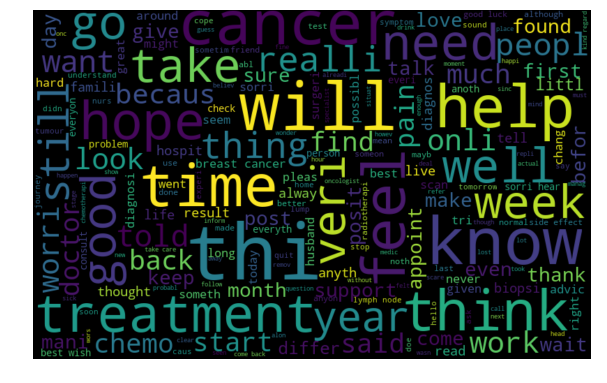

In [7]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [8]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [9]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(combi['tidy_text'])

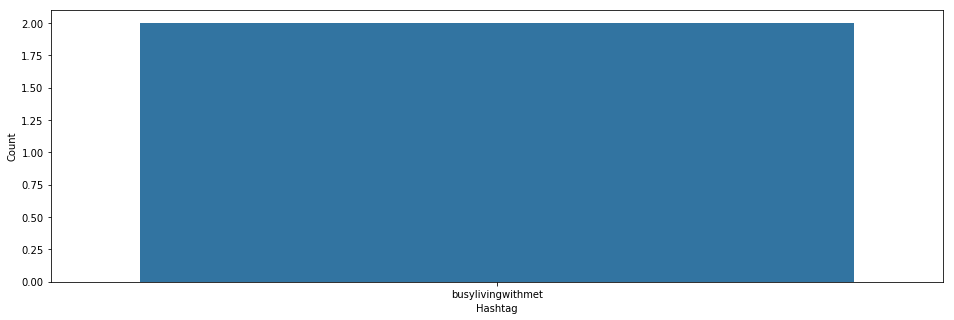

In [10]:
# unnesting list
HT_regular = sum(HT_regular,[])
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_text'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_text'])

In [13]:
import pickle
pkl_filename = "scraped_data/pickle_model.pkl"  
# Load from file
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)

In [14]:
# Calculate the predict target values
print(pickle_model)
prediction = pickle_model.predict_proba(tfidf)
Ypredict = pickle_model.predict(bow) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [15]:
prediction.mean()

0.5

In [16]:
Ypredict.mean()

0.09962009286618827

In [17]:
prediction.max()

0.9970795551598448

In [18]:
Ypredict.max()

1

In [19]:
prediction.min()

0.0029204448401551567

In [20]:
Ypredict.min()

0

In [21]:
%load_ext autoreload
%autoreload

In [23]:
#### processing text from here
import processing

In [24]:
combi['tidy_text'].apply(lambda x: processing.get_hyponyms(x))

0                                        {'Hyponyms': []}
1                                        {'Hyponyms': []}
2                                        {'Hyponyms': []}
3                                        {'Hyponyms': []}
4                                        {'Hyponyms': []}
5                              {'Hyponyms': ['velleity']}
6                                        {'Hyponyms': []}
7       {'Hyponyms': ['roller_coaster', 'big_dipper', ...
8                                        {'Hyponyms': []}
9                                        {'Hyponyms': []}
10              {'Hyponyms': ['conspicuous_consumption']}
11                         {'Hyponyms': ['common_touch']}
12                                       {'Hyponyms': []}
13                 {'Hyponyms': ['overdo', 'exaggerate']}
14                                       {'Hyponyms': []}
15      {'Hyponyms': ['acknowledge', 'recognize', 'rec...
16                                       {'Hyponyms': []}
17            

In [26]:
combi['tidy_text'].apply(lambda x: processing.get_stanford_pos(x))

LookupError: Could not find stanford-postagger.jar jar file at E:\Work\discussions-text-analysis\cancer\stanford\stanford-postagger

In [28]:
combi['tidy_text'].apply(lambda x: processing.get_stanford_named_entity(x))

LookupError: 

===========================================================================
NLTK was unable to find the java file!
Use software specific configuration paramaters or set the JAVAHOME environment variable.
===========================================================================

In [29]:
combi['tidy_text'].apply(lambda x: processing.get_topic(x))

Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic


Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic


Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic
Failed to get topic


0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
2339    False
2340    False
2341    False
2342    False
2343    False
2344    False
2345    False
2346    False
2347    False
2348    False
2349    False
2350    False
2351    False
2352    False
2353    False
2354    False
2355    False
2356    False
2357    False
2358    False
2359    False
2360    False
2361    False
2362    False
2363    False
2364    False
2365    False
2366    False
2367    False
2368    False
Name: tidy_text, Length: 2369, dtype: bool

In [30]:
combi['tidy_text'].apply(lambda x: processing.get_human_names(x))

0       []
1       []
2       []
3       []
4       []
5       []
6       []
7       []
8       []
9       []
10      []
11      []
12      []
13      []
14      []
15      []
16      []
17      []
18      []
19      []
20      []
21      []
22      []
23      []
24      []
25      []
26      []
27      []
28      []
29      []
        ..
2339    []
2340    []
2341    []
2342    []
2343    []
2344    []
2345    []
2346    []
2347    []
2348    []
2349    []
2350    []
2351    []
2352    []
2353    []
2354    []
2355    []
2356    []
2357    []
2358    []
2359    []
2360    []
2361    []
2362    []
2363    []
2364    []
2365    []
2366    []
2367    []
2368    []
Name: tidy_text, Length: 2369, dtype: object

In [31]:
combi['tidy_text'].apply(lambda x: processing.RateSentiment(x))

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
combi['tidy_text']